In [6]:
import keras

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [8]:
#from pykalman import KalmanFilter

In [9]:
# read training data 
train_df = pd.read_csv('PM_train_02.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [10]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [11]:
train_df.columns
cols = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [12]:
# read test data
test_df = pd.read_csv('PM_test_02.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [13]:
# read ground truth data
truth_df = pd.read_csv('PM_truth_02.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [14]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [15]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [16]:
# generate label columns for training data
w1 = 30
w0 = 24
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,9.3461,0.02,334,2223,100.00,14.73,8.8071,148,0,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,9.3774,0.02,330,2212,100.00,10.41,6.2665,147,0,0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,10.8941,0.02,309,1915,84.93,14.08,8.6723,146,0,0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,9.3528,0.02,329,2212,100.00,10.59,6.4701,145,0,0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,10.8963,0.02,309,1915,84.93,14.13,8.5286,144,0,0


In [17]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.0,0.322917,0.651163,1.0,0.156036,0.159082,148,0,0,0.000000
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.0,0.281250,0.627907,1.0,0.007888,0.014562,147,0,0,0.002653
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.0,0.062500,0.000000,0.0,0.133745,0.151414,146,0,0,0.005305
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.0,0.270833,0.627907,1.0,0.014060,0.026144,145,0,0,0.007958
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.0,0.062500,0.000000,0.0,0.135460,0.143240,144,0,0,0.010610


In [18]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,...,0.993662,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,...,0.993496,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,...,0.992477,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,...,0.992394,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,...,0.001213,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610


In [19]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [20]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,...,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000,275
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,...,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653,274
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,...,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305,273
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,...,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958,272
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,...,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610,271


In [21]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,...,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000,275,0,0
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,...,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653,274,0,0
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,...,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305,273,0,0
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,...,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958,272,0,0
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,...,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610,271,0,0


In [29]:
train_target=train_df['label1']
test_target=test_df['label1']
train=train_df.drop(['RUL','label1','label2'],axis=1)
test=test_df.drop(['RUL','label1','label2'],axis=1)

In [30]:
train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082,0.000000
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562,0.002653
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414,0.005305
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144,0.007958
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240,0.010610


In [31]:
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,...,0.993662,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,...,0.993496,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,...,0.992477,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,...,0.992394,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,...,0.001213,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610


In [169]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=500,max_depth=30)
clf.fit(train,train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [170]:
score = clf.score(train,train_target)

In [171]:
score

1.0

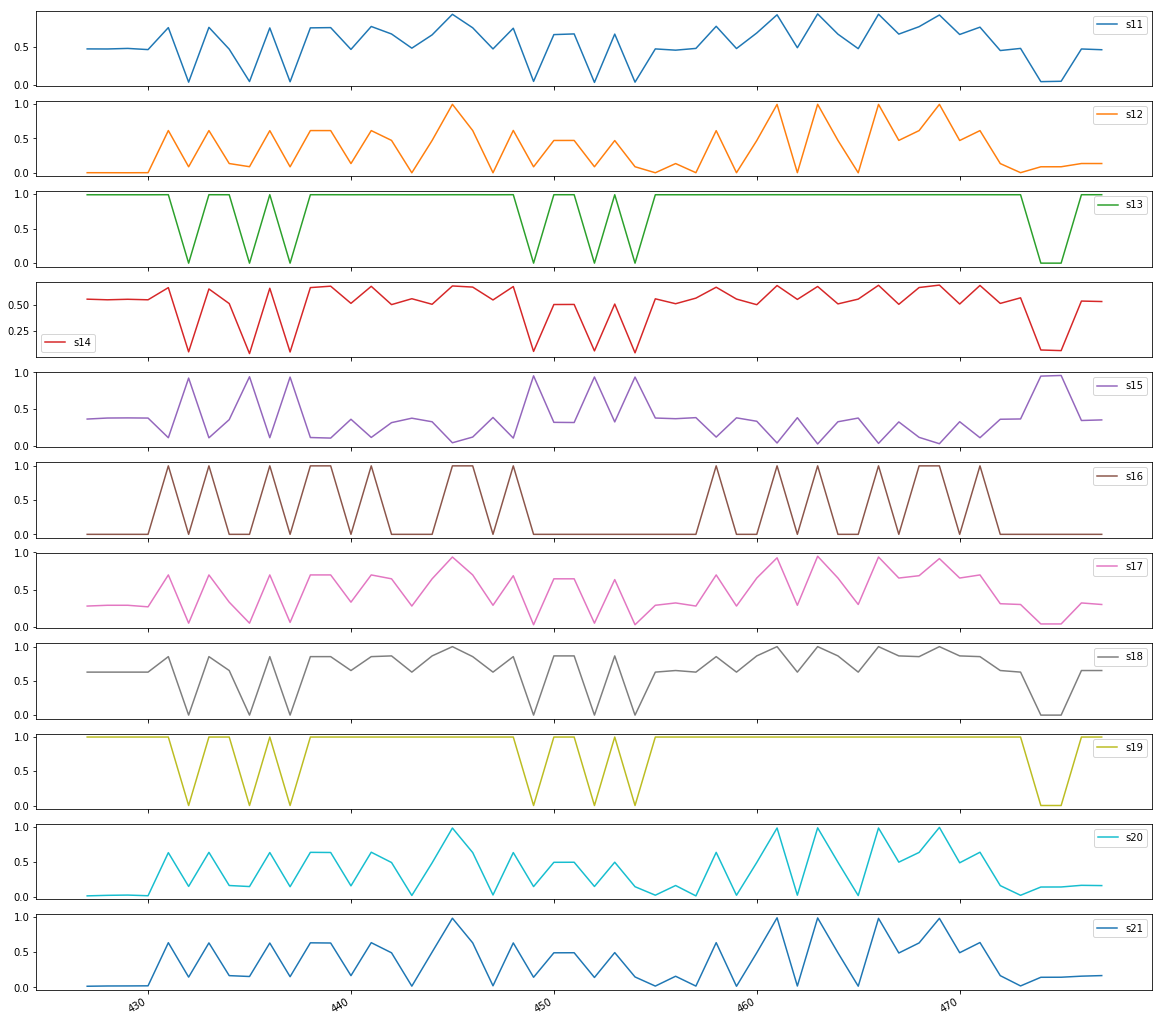

In [147]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [108]:
# pick a large window size of 50 cycles
sequence_length = 50

# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

from keras.callbacks import EarlyStopping, ModelCheckpoint

STAMP = 'predictive_binary_final'
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=2)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

%%time
# fit the network
model.fit(seq_array, label_array, epochs=1000, batch_size=200, validation_split=0.05, verbose=1,callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)

SyntaxError: invalid syntax (<ipython-input-108-047fbc8bfbd9>, line 82)

In [172]:
scores_test = clf.score(train,train_target)
print('Accurracy: {}'.format(scores_test))

Accurracy: 1.0


In [173]:
# make predictions and compute confusion matrix
y_pred = clf.predict(train)
y_true = train_target
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[45699,     0],
       [    0,  8060]], dtype=int64)

In [174]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [175]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  1.0 
 recall =  1.0


In [ ]:
# seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
#                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

# seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
# seq_array_test_last.shape

# y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

# label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
# label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
# label_array_test_last.shape

# print(seq_array_test_last.shape)
# print(label_array_test_last.shape)

In [ ]:
# test metrics
scores_test = clf.score(test,test_target)
print('Accurracy: {}'.format(scores_test))

In [ ]:
# make predictions and compute confusion matrix
y_pred_test = clf.predict(test)
y_true_test = test_target
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

In [ ]:
results_df = pd.DataFrame([[scores_test,precision_test,recall_test,f1_test],
                          ],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df